In [52]:
%load_ext autoreload
from scipy.signal import medfilt

%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session

name= 'pk6388-18102022-0101'
#name= 'pk4160-21102022-0101'
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path: /adata/electro/pk6388/pk6388-18102022-0101/
Mouse: pk6388
Session: 18102022-0101
Name: pk6388-18102022-0101 , pk6388-18102022-0101

Path: OK


In [54]:
## get the session object 

ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files(ignore_params=True)  # ignore_params if kilosort has not been executed so far
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk6388-18102022-0101
path = /adata/electro/pk6388/pk6388-18102022-0101
subject = pk6388
session_dat_time = 2022-10-18 01:01:00
fileBase = /adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101
file_names = {'par': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.par', 'desen': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.desen', 'desel': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.desel', 'sampling_rate': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.sampling_rate_dat', 'stimulation': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.stimulation', 'px_per_cm': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.px_per_cm', 'setup': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.setup', 'environmentFamiliarity': '/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.environmentFamiliarity', 'params':

## load spikes and waveform

In [55]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)#, only_good=False)
print("stl.clu_ids",len(stl.clu_ids), stl.clu_ids)
cg = Cell_group(stl)

cg.set_info_from_session(ses, maxchannels=5)

stl.clu_ids 20 [  8  20  28  35  36  38  39  53  54  72  78  81  84  95 102 111 112 124
 130 135]
Templates: 82 , timepoints: 82 , Channels: 64
Loaded templates-clusters-map, spikes: 744705 , clusters: 98
Init shanks: 8


For each cluster, print the active channels where the spikes were detected, and the corresponding brain area.

In [56]:
unique, counts = np.unique([ '/'.join(n.brain_area) for n in cg.neuron_list ] , return_counts=True )

for u,c in zip(unique, counts):
    print(u,":",c)

mec : 16
mec/pos : 1
pos : 3


## create pose file 

In [57]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.pose.npy
load from saved pose file


## overwiew

In [58]:
### set the intervals
iv=ses.trial_intervals.inter
print("use interval",iv)


### get the arena diameter and xy range
arena, diameter, *_ = ses.session_trials()[0][3]
print("arena:", arena)
print("diameter:", diameter)

# diameter=70.
# arena="square"

xy_range=ap.find_xy_range(diameter=diameter)
xyrange_min,xyrange_max=xy_range
xmean,ymean = ap.meanloc
center = np.mean(xy_range, axis=0)
print("xmean,ymean",xmean,ymean)
print("xyrange_min,xyrange_max",xyrange_min,xyrange_max)
print("center", center)

use interval [[   0.      2866.75195]]
arena: square
diameter: 70.0
xmean,ymean 48.8478574265765 69.14476109879887
xyrange_min,xyrange_max [13.84785743 23.        ] [83.84785743 93.        ]
center [48.84785743 58.        ]


i 0 / n 8
i 1 / n 20
i 2 / n 28
i 3 / n 35
i 4 / n 36
i 5 / n 38
i 6 / n 39
i 7 / n 53
i 8 / n 54
HD mec
i 9 / n 72
i 10 / n 78
i 11 / n 81
i 12 / n 84
i 13 / n 95
i 14 / n 102
i 15 / n 111
i 16 / n 112
i 17 / n 124
HD pos
i 18 / n 130
i 19 / n 135


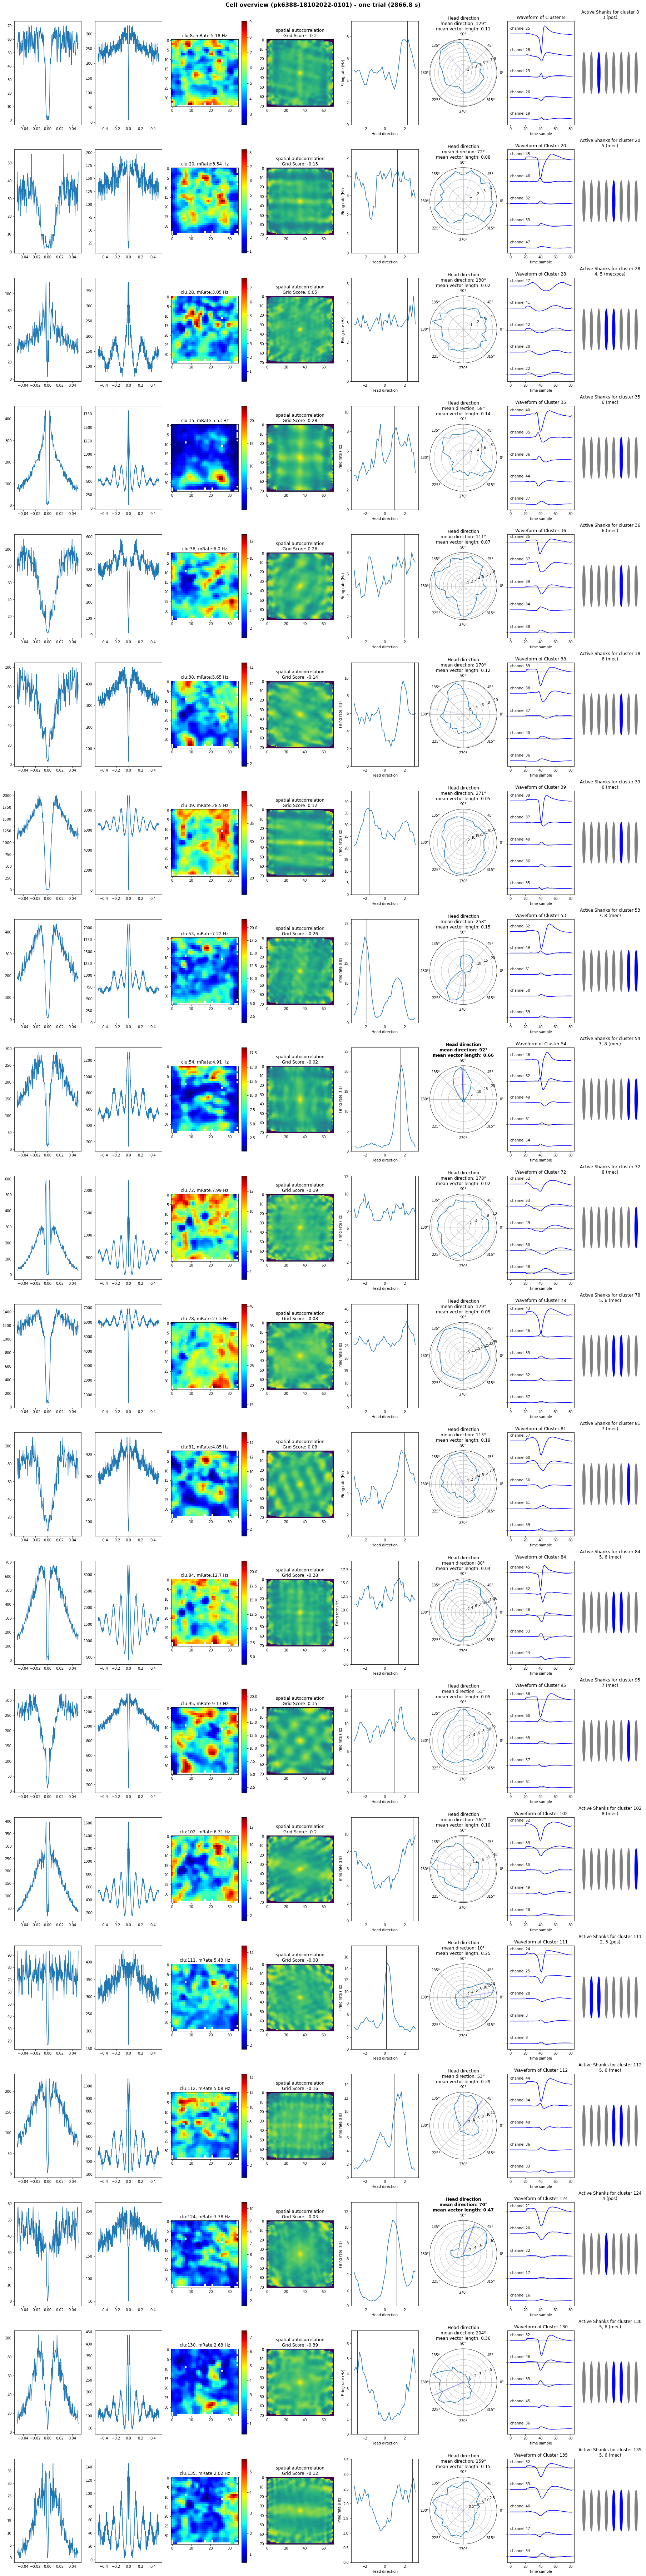

<Figure size 432x288 with 0 Axes>

In [59]:
hd_firing_list=[] # neurons tuning curve
hd_ifr_list=[] # ifr list
spike_trains = [] # spike trains


# from matplotlib.patches import Rectangle

cols = 8

fig, axs = plt.subplots(len(cg.neuron_list), cols, figsize=(25, 5*len(cg.neuron_list)), squeeze=False, constrained_layout=True)
   
for i, n in enumerate(cg.neuron_list):
    
    # first interval only
    # iv = ses.trial_intervals.inter[0]
    # iv = np.array([iv])
    # custom interval (first 20min of light-dark-protocol -> light baseline)
    # iv=np.array([0.,1200.])
    #iv=np.array([6000.,7200.]) # last 20mins
    #iv=light_intervals
    # iv=np.array(first_block)

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    ap.set_intervals(iv)
    
    n.set_spatial_properties(ap)
    
    print("i",i,"/","n",n.name)
    #print("n",n.spike_train.intervals.total_interval_duration_seconds())
    #print("ap",ap.intervals.total_interval_duration_seconds())
    
    
    
    # temporal auto-correlation
      
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,0].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,1].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    
    # clear intervals
    
    # n.spike_train.unset_intervals()
    # ap.unset_intervals()
    # n.spike_train.set_intervals(ses.trial_intervals.inter)
    # ap.set_intervals(ses.trial_intervals.inter)
    
    # spatial firing map 
    
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True, xy_range=xy_range) # xy_range
    im = axs[i,2].imshow(n.spatial_properties.firing_rate_map.T,cmap='jet')
    axs[i,2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
    fig.colorbar(im,ax=axs[i,2])
    
    
    # Spatial autocorrelation Map & Grid Score
    gs = n.spatial_properties.grid_score()
    
    fw = "bold" if gs>.4 else "normal"
    
    axs[i,3].imshow(n.spatial_properties.spatial_autocorrelation_map)
    axs[i,3].set_title("spatial autocorrelation"+"\n"+"Grid Score: "+str(round(gs,2)), fontweight=fw)
    
    # Head direction
    
    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    
    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    axs[i,4].plot(angles, hd_firing)
    axs[i,4].set_xlabel("Head direction")
    axs[i,4].set_ylabel("Firing rate (Hz)")
    axs[i,4].set_ylim(0, np.nanmax(n.spatial_properties.firing_rate_head_direction_histo)*1.2+0.1)
    axs[i,4].axvline(x=hd_mean_direction_rad, color="black")
    #axs[i,4].text(s=str(round(hd_mean_direction_rad*180./np.pi))+" ° (vector length = "+str(hd_mean_vector_length)+")",x=hd_mean+.1,y=1)
    
    fw = "bold" if hd_mean_vector_length>.4 else "normal"
    axs[i,5].axis('off')
    ax2 = fig.add_subplot(len(cg.neuron_list), cols, cols*i+6, polar=True)
    #ax2.plot(angles, hd_firing)
    ax2.plot(np.append(angles,angles[0]), np.append(hd_firing,hd_firing[0]))
    ax2.plot([hd_mean_direction_rad]*2, [0,max(hd_firing)] , color="blue", alpha=hd_mean_vector_length if np.isfinite(hd_mean_vector_length) else 0., lw=2.5  )
    if np.isfinite(hd_mean_direction_deg) and np.isfinite(hd_mean_vector_length):
        ax2.set_title("Head direction" + "\n" + "mean direction: " + str(round( (hd_mean_direction_deg + 360) % 360  )) +"°" + "\n" + "mean vector length: " + str(np.round(hd_mean_vector_length,2))  , fontweight=fw) 
    else:
        ax2.set_title("Head direction: no data")
    ax2.grid(True)

    
    
    # Waveforms
    
    cluster = int(n.name) # current cluster name
    channels = ses.get_channels_from_cluster(cluster) # get channels with highest amplitude
    
    if (len(channels)):
    
        for j,channel in enumerate(channels):
            channel_mapped, waveform = ses.get_waveform_from_cluster(cluster, channel)
            axs[i,6].axhline( y = -j*.5 , color="grey" , lw=.5 )
            #label = "channel: "+str(channel)+" ("+str(channel_mapped)+")"
            label = "channel "+str(channel_mapped)
            axs[i,6].plot( waveform -j*.5 , label=label , color="blue")
            axs[i,6].text( s= label , x=0, y=-j*.5 +.1 )
        axs[i,6].set_xlabel("time sample")
        axs[i,6].set(yticklabels=[])  
        axs[i,6].set_title("Waveform of Cluster "+str(cluster))
        
        
    
    # channels / shanks / brain region
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(channels)
    brain_region = '/'.join(electrodes)
   
    for j, (shank, active) in enumerate(zip(ses.shanks_all, shanks_arr)):
        color = 'blue' if active else 'gray'
        circle = plt.Circle((j,0), 0.2, color=color)
        axs[i,7].add_patch(circle)

    
    axs[i,7].axis('off')
    axs[i,7].set_title("Active Shanks for cluster "+str(cluster)+"\n"+', '.join([str(int(active_shank)) for active_shank in active_shanks]) + " ("+brain_region+")")
    
    axs[i,7].set_xlim([-1, len(ses.shanks_all)])
    axs[i,7].set_ylim([-0.5, 0.5])

    
    
    
    ###########################
    # classify, find category: Grid cell, HD cell
    
    #if i in [0,3,8,9,10,11,13,14,32]:
    # #if i in [18,19,20,23,25,29]:
    #if i in [11,12,13]:
    # if (n.name in ['20','43','45']):
    if (hd_mean_vector_length > 0.4 and hd_peak_rate > 10):
        print("HD", brain_region)
        n.spike_train.instantaneous_firing_rate(bin_size_sec=2.e-2)
        #~ print("n.name",n.name)
        #~ print("n.spike_train.ifr",n.spike_train.ifr)
        #~ print("n.spike_train.st",n.spike_train.st)
        
        hd_firing_list.append(hd_firing)
        hd_ifr_list.append(n.spike_train.ifr)
        spike_trains.append(n.spike_train.st)
        
        #rect = Rectangle((0.08, 1-(i+.5)/len(cg.neuron_list)), 0.85, 1/len(cg.neuron_list), facecolor='yellow', edgecolor='none', transform=fig.transFigure, zorder=-1)
        #fig.patches.append(rect)
        
    if gs>.4:
        print("GC", brain_region)

    
    
plt.suptitle("Cell overview ({}) - one trial ({:.1f} s)".format(name, n.spike_train.intervals.total_interval_duration_seconds()), fontsize=16, fontweight='bold')
#plt.tight_layout()
#
#fig.subplots_adjust(wspace=0.33, hspace=.5)
# fig.subplots_adjust(wspace=0.33, hspace=.5, top=0.95)
#fig.subplots_adjust(wspace=0.33, hspace=.5, top=1-.03-1/(len(cg.neuron_list)+5))
#~ 
plt.show()
plt.savefig('/home/maryam/Desktop/DataAnalyzing/Pascal/'+name+'.pdf')
plt.savefig(path+name+'.pdf')


In [60]:
path+name+'.pdf'

'/adata/electro/pk6388/pk6388-18102022-0101/pk6388-18102022-0101.pdf'